# Data Analysis with NYC airbnb data 

Brief Introduction: Airbnb, Inc. is an online marketplace for arranging or offering loding, primarily homestays, or tourism experiences. The company does not own any of the real estate listings, nor does it host events; it actas a broker, receiving commissions from each booking
([Source](https://en.wikipedia.org/wiki/Airbnb))

This project will analyze and provide insights on the demographic characteristic of the NYC airbnb hosts. We will also touch base on pricing prediction model to provide a pricing guideline for future airbnb host

The data used in this project is [NYC Airbnb Open Data](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data )


## TABLE OF CONTENTS
1. [__Preprocessing and EDA__](#1)
    - [Importing and Cleaning Data](#1.1)
    - [Data Visualization and Exploration](#1.2)
    - [Feature Engineering](#1.3)  <br><br>
    
2. [__Modeling__](#2)

__Note__: Currently working on tuning the model to get a better performance

<img src ='airbnb-logo-625x352.jpg'>

In [1]:
!pip install xgboost
!pip install lightgbm

In [2]:
# importing library 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import warnings
from PIL import Image
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

## 1. Preprocessing and Data Exploration <a id='1'></a>

### 1.1. Importing and Cleaning Data <a id='1.1'></a>


In [3]:
# Loading data into notebook and convert to appropriate data types
try:
    nyc_img = Image.open('New_York_city_.png')
except IOError:
    pass
types = {'id':'int64', 'name':'str', 'neighbourhood_group':'object', 
         'room_type':'category', 'price': 'float'}
airbnb = pd.read_csv('AB_NYC_2019.csv', sep = ',', dtype = types)
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'])
print(airbnb.shape)
print(airbnb.dtypes)

(48895, 16)
id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                               category
price                                    float64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object


In [4]:
# take a brief look at the data 
airbnb.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150.0,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10,9,2018-11-19,0.10,1,0


In [5]:
# remove duplicated values if there i any
airbnb.duplicated().sum()
airbnb.drop_duplicates(inplace = True)

In [6]:
# Summary statisics for feature column
print(airbnb['room_type'].unique())
print(airbnb['neighbourhood_group'].unique())
print(airbnb[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']].describe().T)

[Private room, Entire home/apt, Shared room]
Categories (3, object): [Private room, Entire home/apt, Shared room]
['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
                     count        mean         std   min    25%     50%  \
price              48895.0  152.720687  240.154170  0.00  69.00  106.00   
minimum_nights     48895.0    7.029962   20.510550  1.00   1.00    3.00   
number_of_reviews  48895.0   23.274466   44.550582  0.00   1.00    5.00   
reviews_per_month  38843.0    1.373221    1.680442  0.01   0.19    0.72   
availability_365   48895.0  112.781327  131.622289  0.00   0.00   45.00   

                      75%      max  
price              175.00  10000.0  
minimum_nights       5.00   1250.0  
number_of_reviews   24.00    629.0  
reviews_per_month    2.02     58.5  
availability_365   227.00    365.0  


In [7]:
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We won't treat the missing values in columns 'host_name' and 'name' since it is not relevant to our data analysis. 'host_id' and 'id' can be used instead of 'host_name' and 'name' (Note: we can drop these 2 columns if wanted but I will keep it just in case). 10052 missing values in 'last_review' and 'reviews_per_month' means that for that specific host, there are no available reviews. We will just change the null value in the 'reviews_per_month' into zeros ( note: fill in the null values with average do not make sense in this case)

In [8]:
airbnb.fillna({'reviews_per_month': 0}, inplace = True)
# check if the change is applied
airbnb['reviews_per_month'].isnull().sum()

0

### 1.2. Data Exploration & Visualization  <a id='1.2'></a>

Let dwell into it a little bit more. First, we will see who has the most listings and which area has the most listings

### a. Listings <a id='a'></a>

In [9]:
most_host = airbnb['host_id'].value_counts().nlargest(5)
print(most_host)
# validate with 'calculated_host_listings_count' column
airbnb['calculated_host_listings_count'].max()

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
Name: host_id, dtype: int64


327

In [10]:
most_host = np.array(most_host)
count = []
for count in most_host:
    print(airbnb['neighbourhood_group'].loc[airbnb['calculated_host_listings_count'] == count].unique())
    print(airbnb[['neighbourhood_group', 'room_type']].loc[airbnb['calculated_host_listings_count'] == count].describe())

['Manhattan']
       neighbourhood_group        room_type
count                  327              327
unique                   1                2
top              Manhattan  Entire home/apt
freq                   327              319
['Manhattan' 'Brooklyn']
       neighbourhood_group        room_type
count                  232              232
unique                   2                1
top              Manhattan  Entire home/apt
freq                   230              232
['Manhattan']
       neighbourhood_group        room_type
count                  121              121
unique                   1                1
top              Manhattan  Entire home/apt
freq                   121              121
['Manhattan' 'Queens' 'Brooklyn']
       neighbourhood_group     room_type
count                  103           103
unique                   3             2
top                 Queens  Private room
freq                    79           101
['Manhattan']
       neighbourhood_group        

We can see that hosting homes are dominantly in the Manhattan and Brookylyn areas for the host in top 6 numbers of listings. The room types are mostly entire home/apt. It makes sense since Manhattan and Brooklyn are tourists attractions in NYC <br> <br>
Let's look at the distribution of listing on map to have a clear picture

Text(0.5, 1.0, 'Listings Distribution')

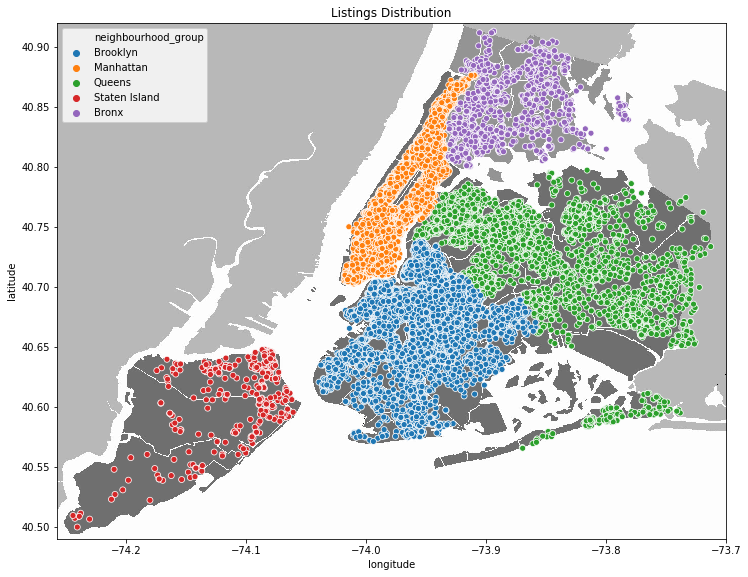

In [11]:
fig, ax = plt.subplots(figsize = (12,12))
#coordinate = [airbnb['longitude'].min(), airbnb['longitude'].max(), airbnb['latitude'].min(), airbnb['latitude'].max()]
coordinate = [-74.258, -73.7, 40.49, 40.92]
ax.imshow(nyc_img, zorder = 0, extent = coordinate) 

sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'neighbourhood_group', 
                ax =ax, data = airbnb)
plt.title('Listings Distribution')

Text(0.5, 1.0, 'Number of listings in neighborhood groups ')

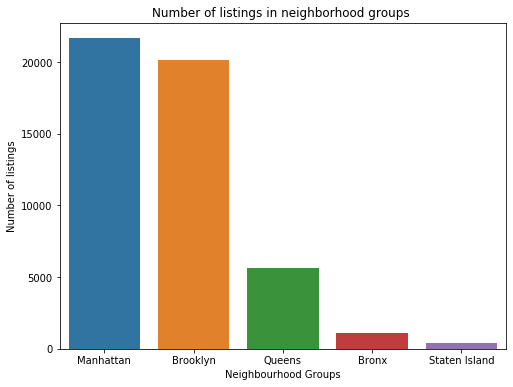

In [12]:
plt.figure(figsize = (8,6))
sns.countplot(x = 'neighbourhood_group',
              order = airbnb['neighbourhood_group'].value_counts().index, data = airbnb)
plt.xlabel('Neighbourhood Groups')
plt.ylabel('Number of listings')
plt.title('Number of listings in neighborhood groups ')

Manhattan and Brooklyn seems to be the two dominant areas for hosting. What about the pricing in each borough?  

### b. Pricing <a id='b'></a>

In [13]:
print(airbnb['price'].quantile(0.99))
print(airbnb['price'][airbnb['price'] > 799].count())

799.0
474


We can see that most of listing prices are less than $800 so we will filter out the price data to make it easier to plot the heat map

Text(0.5, 1.0, 'Price Distribution within each borough')

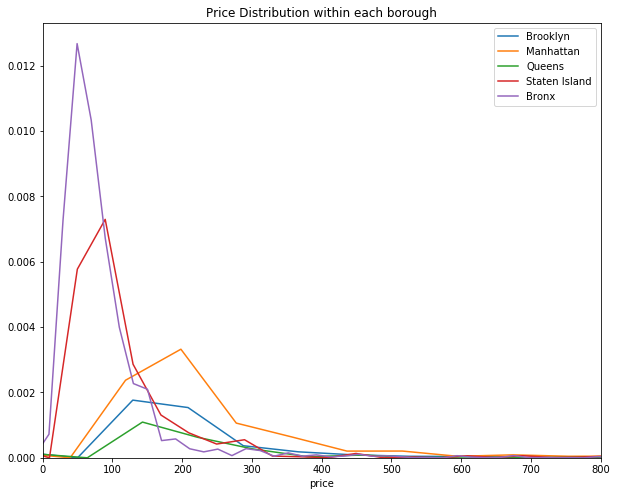

In [14]:
plt.figure(figsize = (10,8))
names = []
for names in airbnb['neighbourhood_group'].unique():
        sns.distplot(airbnb[airbnb['neighbourhood_group'] == names].price
                 ,hist = False, label = names) 
plt.xlim(0,800)
plt.title('Price Distribution within each borough')

Text(0.5, 1.0, 'Pricing Distribution')

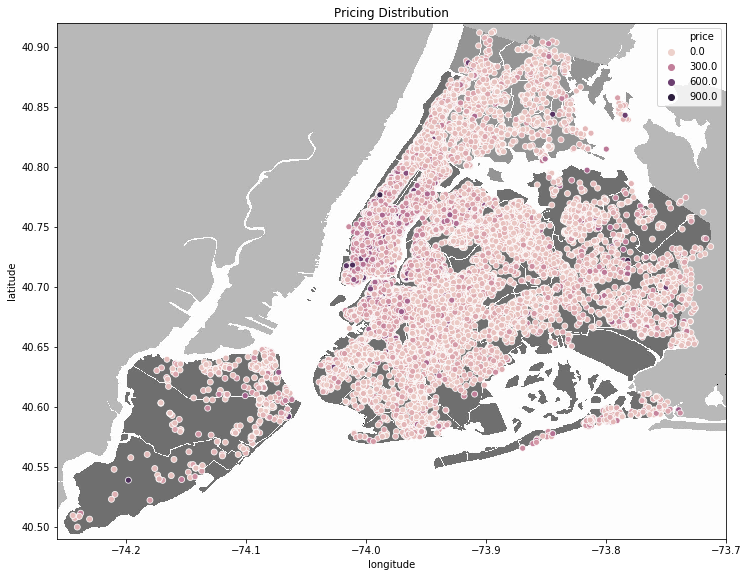

In [15]:
fig, ax = plt.subplots(figsize = (12,12))
#coordinate = [airbnb['longitude'].min(), airbnb['longitude'].max(), airbnb['latitude'].min(), airbnb['latitude'].max()]
coordinate = [-74.258, -73.7, 40.49, 40.92]
ax.imshow(nyc_img, zorder = 0, extent = coordinate) 
airbnb_part = airbnb[airbnb['price'] < 800]
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'price',  cmap = plt.get_cmap('jet') , alpha = 1,
                ax =ax, data = airbnb_part)
plt.title('Pricing Distribution')

The expensive listings are concentrated in Manhattan

(0, 800)

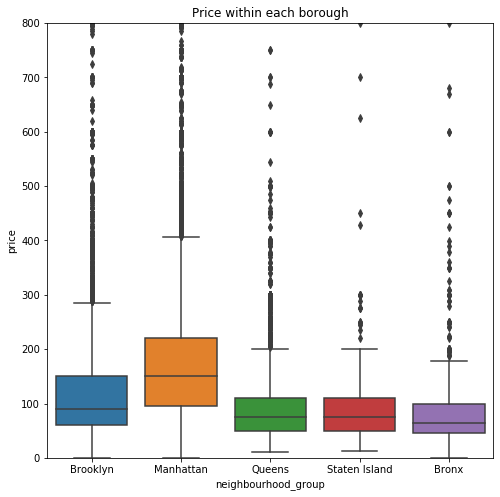

In [16]:
plt.figure(figsize  = (8,8))
sns.boxplot(x = 'neighbourhood_group', y = 'price', data = airbnb)
plt.title('Price within each borough')
plt.ylim(0,800)

Averagely, Manhattan and Brooklyn has the most expensive accomodation. Let's look the pricing distribution on the map to have a clear view.

Text(0.5, 1.0, 'Share of Room Types within Neighbourhood Groups ')

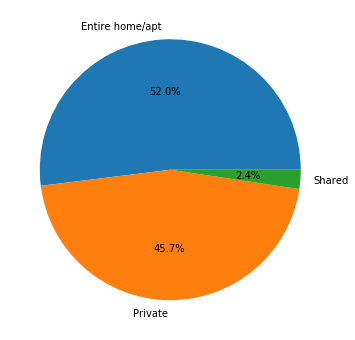

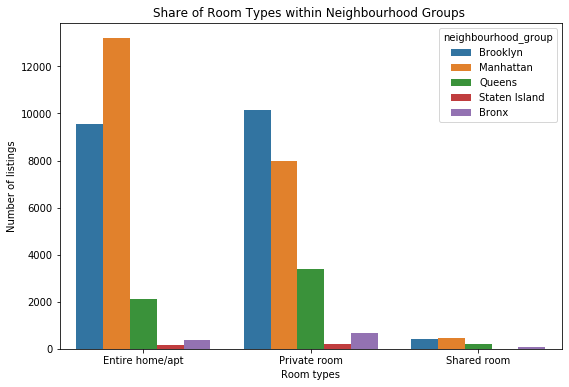

In [17]:
plt.figure(figsize = (6,6))
plt.pie(airbnb['room_type'].value_counts(), 
        labels = ['Entire home/apt', 'Private', 'Shared'], autopct='%1.1f%%', data = airbnb)

plt.figure(figsize = (9,6))
sns.countplot(x = 'room_type', hue = 'neighbourhood_group', data = airbnb)
plt.xlabel('Room types')
plt.ylabel('Number of listings')
plt.title('Share of Room Types within Neighbourhood Groups ')

We can see that most of listings are in entire home/apt and private room types. Next, lets look into the map and analyze the distribution of availability of room. 

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1091.0,87.496792,106.709349,0.0,45.0,65.0,99.0,2500.0
Brooklyn,20104.0,124.383207,186.873538,0.0,60.0,90.0,150.0,10000.0
Manhattan,21661.0,196.875814,291.383183,0.0,95.0,150.0,220.0,10000.0
Queens,5666.0,99.517649,167.102155,10.0,50.0,75.0,110.0,10000.0
Staten Island,373.0,114.812332,277.620403,13.0,50.0,75.0,110.0,5000.0


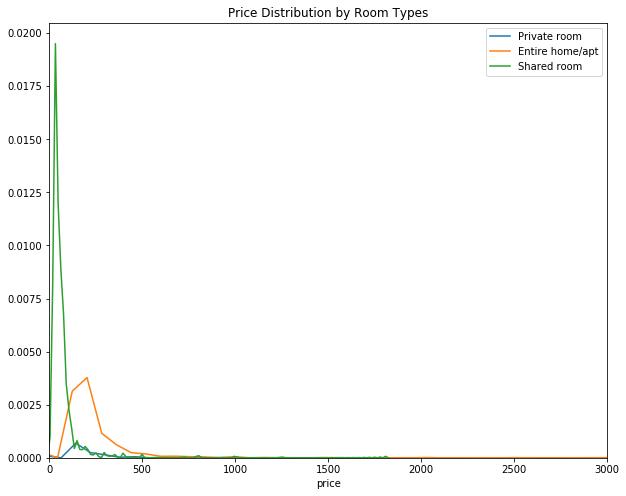

In [18]:
plt.figure(figsize = (10,8))
names = []
for names in airbnb['room_type'].unique():
        sns.distplot(airbnb[airbnb['room_type'] == names].price
                 ,hist = False, label = names) 
plt.xlim(0,3000)
plt.title('Price Distribution by Room Types')

airbnb.groupby('neighbourhood_group')['price'].describe()


Clearly, shared room's cost is the cheapest and entire room/apt is generally the most costly when we look at the distribution plot above. Lets see how price is related to those 

### c. Number of Reviews <a id='c'></a>

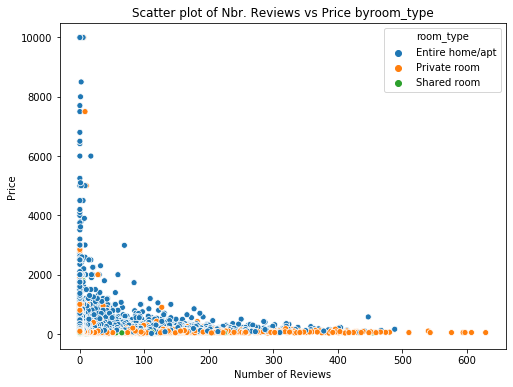

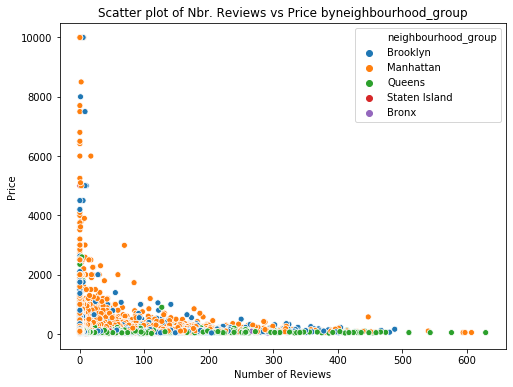

In [19]:
hueopt = ['room_type', 'neighbourhood_group']
segment = []
for segment in hueopt: 
    plt.figure(figsize=(8,6))
    sns.scatterplot(airbnb['number_of_reviews'], airbnb['price'], hue = airbnb[segment])
    plt.xlabel('Number of Reviews')
    plt.ylabel('Price')
    plt.title('Scatter plot of Nbr. Reviews vs Price by' + str(segment))

Most of reviews are from host with relatively low price , approximately less than $1000. Highest numbers of reviews come from private room followed by entire home/apt. What about availability? Is there any relationship between availability in different areas and room type

### d. Availability <a id='d'></a>

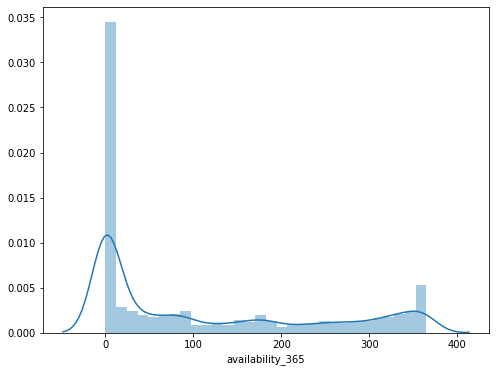

In [20]:
plt.figure(figsize = (8,6))
sns.distplot(airbnb['availability_365'])

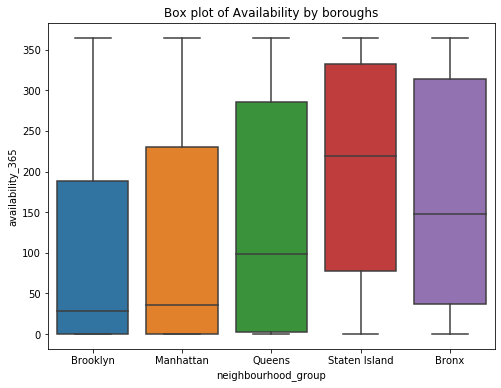

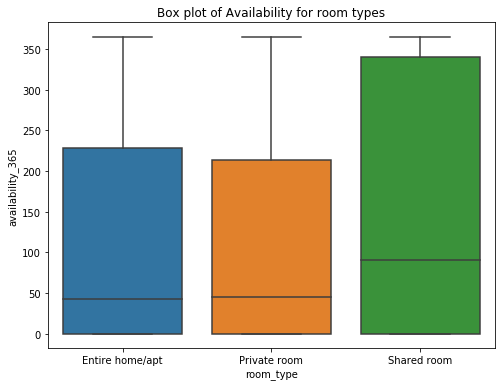

In [21]:
plt.figure(figsize = (8,6))
sns.boxplot(x = 'neighbourhood_group', y ='availability_365', data = airbnb)
plt.title('Box plot of Availability by boroughs') 
plt.show()

plt.figure(figsize = (8,6))
sns.boxplot(x = 'room_type', y = 'availability_365', data = airbnb)
plt.title('Box plot of Availability for room types')
plt.show()

There are a lot more availability in Staten Island, Bronx and Queen during a year compared to Manhattan and Brooklyn. Is it because these are a less popular hosting areas? <br> <br>
Shared room's availabilty is a lot higher than Entire home and private room options. is this because shared room's are also a less popular hosting option? <br> <br>
Other reason may be Manhattan and Brooklyn being the business centre and tourist attraction

### 1.3. Feature Engineering <a id='1.3'></a>

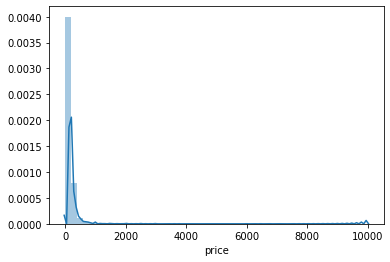

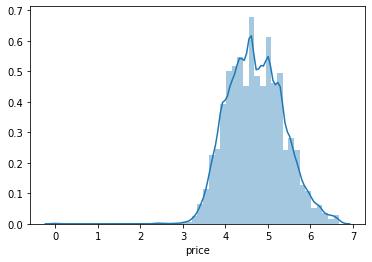

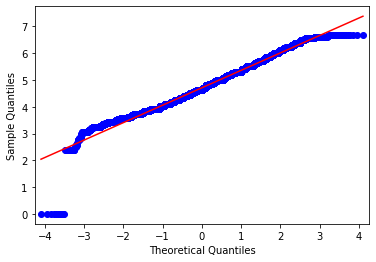

In [22]:
sns.distplot(airbnb['price'], hist = True); plt.show()
sns.distplot(np.log(airbnb_part['price']+1)); plt.show()
qqplot(np.log(airbnb_part['price']+1), line = 's'); plt.show()

We can see that _price_ data is highly right-skewed so we will transform it to _log(price+1)_ in order for it to be more _'normal'_. <br> <br>
We are using airbnb part to remove certain outliers which will hurt our calculation. To make a more accurate prediction. We will adjust the data for price less than 800 (99 percentile) 

In [23]:
airbnb_part['price'] = np.log(airbnb_part['price']+1)
X_price = airbnb_part[['neighbourhood_group', 'room_type', 'minimum_nights', 'availability_365', 'calculated_host_listings_count', 'number_of_reviews']]
Y_price = airbnb_part[['price']]
print('Independent Variables: \n')
print(X_price.head(5))
print('Dendendent Variables: \n')
print(Y_price.head(5))

Independent Variables: 

  neighbourhood_group        room_type  minimum_nights  availability_365  \
0            Brooklyn     Private room               1               365   
1           Manhattan  Entire home/apt               1               355   
2           Manhattan     Private room               3               365   
3            Brooklyn  Entire home/apt               1               194   
4           Manhattan  Entire home/apt              10                 0   

   calculated_host_listings_count  number_of_reviews  
0                               6                  9  
1                               2                 45  
2                               1                  0  
3                               1                270  
4                               1                  9  
Dendendent Variables: 

      price
0  5.010635
1  5.420535
2  5.017280
3  4.499810
4  4.394449


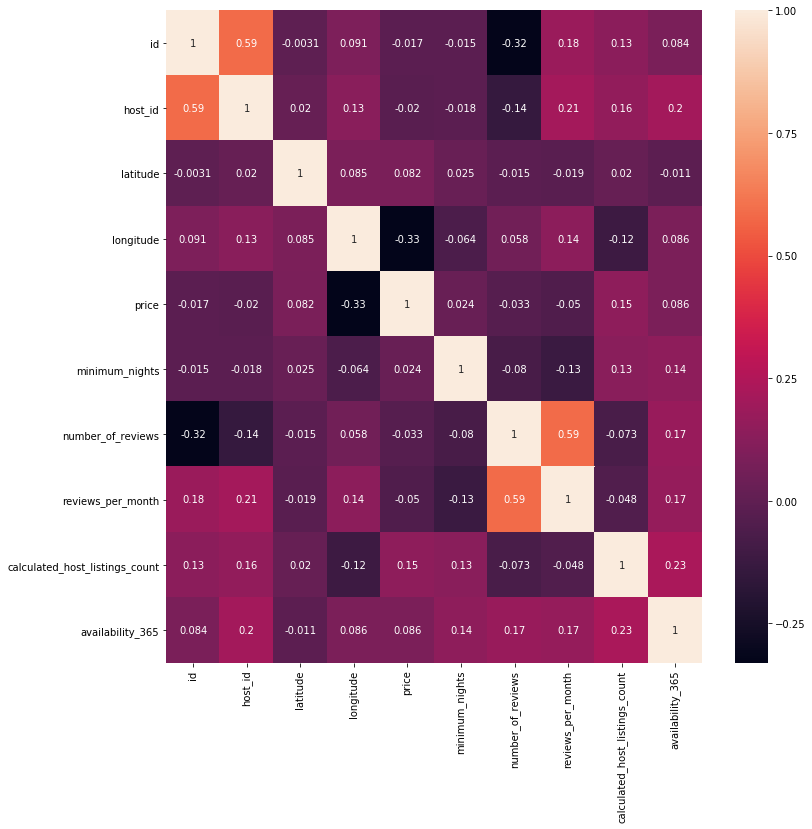

In [24]:
f = plt.figure(figsize = (12,12))
sns.heatmap(airbnb_part.corr(), annot = True)

In [25]:
# One hot encoding
cat_feature = X_price.select_dtypes(include=['object','category'])
cat_one_hot = pd.get_dummies(cat_feature)
num_feature = X_price.select_dtypes(exclude=['object','category'])
X = np.concatenate((cat_one_hot,num_feature), axis = 1)
Y = Y_price

In [26]:
# Split data into test and train set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 138)
print(X_train.shape) ; print(X_test.shape); print(Y_train.shape); print(X_test.shape)

(38736, 12)
(9685, 12)
(38736, 1)
(9685, 12)


In [27]:
# Scaling
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 2. Prediction Model <a id='2'></a>


In [28]:
np.random.seed(0)

In [29]:
def print_metrics(y_true, y_predicted):
    ## First compute R^2 and the adjusted R^2
    r2 = r2_score(y_true, y_predicted)    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(np.sqrt(mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(mean_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))

### Linear regression

In [30]:
model = LinearRegression()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
    
print_metrics(Y_test, Y_pred)  

Mean Square Error      = 0.22253072243499006
Root Mean Square Error = 0.47173162119471074
Mean Absolute Error    = 0.3554457624028942
R^2                    = 0.4926616809647747


### Lasso

In [31]:
model = Lasso(0.0001)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print_metrics(Y_test, Y_pred)  

Mean Square Error      = 0.22248413841100087
Root Mean Square Error = 0.471682243052461
Mean Absolute Error    = 0.3554278173528871
R^2                    = 0.4927678858975856


### Random Forest

In [32]:
model = RandomForestRegressor()
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print_metrics(Y_test, Y_pred)  

Mean Square Error      = 0.25188612837537866
Root Mean Square Error = 0.5018825842519131
Mean Absolute Error    = 0.377846578938967
R^2                    = 0.4257355408730654


### Extreme Boosting

In [34]:
model = XGBRegressor(n_estimators = 1000, learning_rate = 0.1, early_stopping = 5,
                     max_depth = 5, min_child_weight = 1, objective='reg:squarederror')
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print_metrics(Y_test, Y_pred)  

Mean Square Error      = 0.206493909493441
Root Mean Square Error = 0.4544160092838291
Mean Absolute Error    = 0.3417948532090473
R^2                    = 0.5292233279653353


### LightGBM

In [35]:
model = LGBMRegressor(num_leaves = 32, learning_rate = 0.2, n_estimators = 50, min_child_sample = 40)
model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
print_metrics(Y_test, Y_pred) 

Mean Square Error      = 0.1976995687379128
Root Mean Square Error = 0.4446341965457817
Mean Absolute Error    = 0.33439350996341033
R^2                    = 0.5492731710032381
